In [37]:
import xarray 
import numpy as np
import scipy.stats
import pandas as pd
#Note that the calibration and calculation data can be the same but they should both be 1-d monthly mean precipitation array and start from January.




def accumulation(data,temporal_scale):  
    # calculate the accumulated n months (temporal_scale) precipitation data
    data_accumulated = np.convolve(data, np.ones(temporal_scale), 'valid')
    # set the value to NANs for the first n-1 months because there isn't accumulated n months values at the first n-1 months
    data_accumulated = np.concatenate([[np.nan]*(temporal_scale-1),data_accumulated])
    
    # If the last year is incomplete, let's set NAN to the months without values in the last year
    n_year_incomplete = len(data_accumulated)/12 - int(len(data_accumulated)/12)
    n_month_incomplete = int(n_year_incomplete * 12)
    data_accumulated = np.concatenate([data_accumulated,[np.nan]*(n_month_incomplete)])
    # Then reshape the 1-d array to 2-d array with the shape of (the number of years, 12) becasue the SPI's distribution and calculation should be based on each month.
    data_accumulated_reshape = data_accumulated.reshape(int(len(data_accumulated)/12),12)
    return data_accumulated_reshape




def gamma_transformation(calibration,calculation,temporal_scale):

    # calculate the alphas and betas at each month based on calibration data
    means = np.nanmean(calibration, axis=0)
    a = np.log(means) - np.nanmean(np.log(calibration), axis=0)
    alphas = (1 + np.sqrt(1 + 4 * a / 3)) / (4 * a)
    betas = means / alphas
    # calculate the probability of 0 values
    n_zero = (calculation ==0).sum()
    n_values = np.count_nonzero(~np.isnan(calculation)) + n_zero
    p_zero = n_zero / len(calculation)

    #set the 0 value as NAN
    calculation[calculation == 0] = np.NaN

    # build gamma distribution based on the non-zero values of calibration data
    #calculate the probability and the values of calculation data under gamma distribution built by calibration data
    p_gamma_non_zero = scipy.stats.gamma.cdf(calculation, a=alphas, scale=betas)
    p_gamma = p_zero + (1-p_zero)*p_gamma_non_zero
    calculation_transformed = scipy.stats.norm.ppf(p_gamma)
    #change the shape to 1-d array
    calculation_transformed = calculation_transformed.flatten()
    return calculation_transformed
    
    
    
def spi(precipitation_calibration:np.ndarray,
        precipitation_calculation:np.ndarray,
        temporal_scale:int,
        distribution = 'gamma',
        upper_limit = 3.09,
        lower_limit = -3.09):
    


    # precipitation_calibration: It should be the 1-d monthly precipitation array used to calibrate the distribution. It must start from January and can be the same as precipitation_calculate. 
    # precipitation_calculate: It should be the 1-d monthly precipitation array used to calculate the SPI_n. It must start from Januaray too.
    # temporal_scale: It's the temporal scale of SPI_n which indicates the number of n months used to calculate accumulated SPI. For example, to calculate SPI3, it should be 3.
    # distribution: The distribution of SPI and right now it only supports gamma distribution which is the most commonly used one.
    # upper_limit, lower_limit: The maximum and minimum SPI values, according to https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1752-1688.1999.tb03592.x , the default values are 3.09 and -3.09.
    
    

    # test if there is missing and negative value 
    #if np.all(np.isnan(precipitation_calibration)):
    #    print("calibration data cannot be all NAN!")
    #if np.all(np.isnan(precipitation_calculation)):
    #    print("calculation data cannot be all NAN!")
        
    if precipitation_calibration[~np.isnan(precipitation_calibration)].min()<0:
        print("Calibration data must be positive! All negative values will be assign to be 0")
        precipitation_calibration.clip(min=0)
    
    if precipitation_calculation[~np.isnan(precipitation_calculation)].min()<0:
        print("Calculation data must be positive! All negative values will be assign to be 0")
        precipitation_calculation.clip(min=0)
        
    #calculate the length of input calculation data
    length_input = len(precipitation_calibration)
        
    #calculate the accumulated precipitation of calibration and calculation data, then reshape them to 2-d array.
    precipitation_calibration_accumulated = accumulation(precipitation_calibration,temporal_scale)
    precipitation_calculation_accumulated = accumulation(precipitation_calculation,temporal_scale)
    
    # apply the gamma transformation to accumulated data
    if distribution == 'gamma':
        spi_n = gamma_transformation(precipitation_calibration_accumulated,
                                    precipitation_calculation_accumulated,
                                    temporal_scale)
        
    # clip the spi values 
    spi_n = np.clip(spi_n,a_min=lower_limit , a_max=upper_limit)
    
    #change spi_n to its original length 
    spi_n =  spi_n[0:length_input]
    return spi_n


Text(0.5, 0, 'Date')

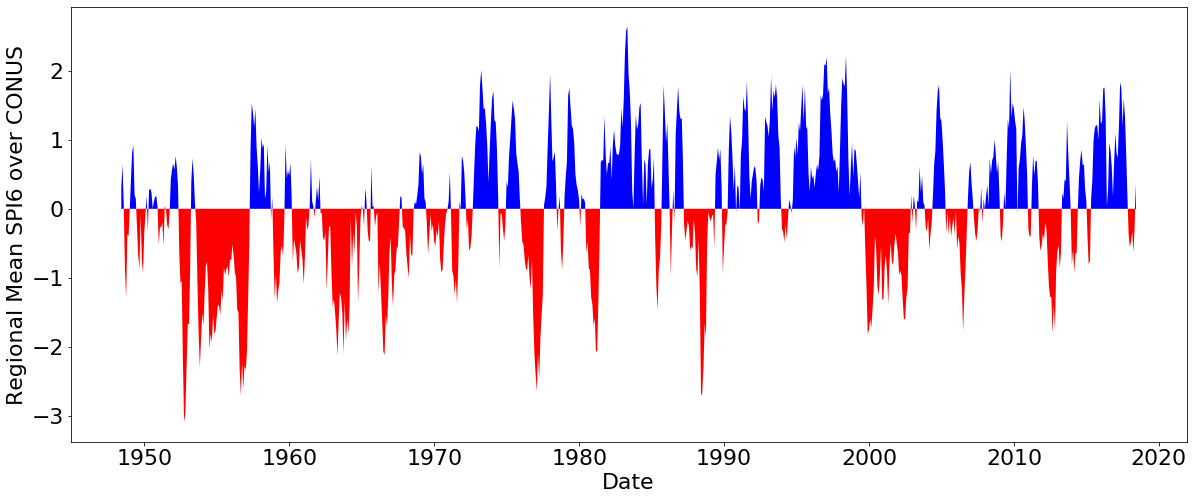

In [38]:
## an example to calculate the regional mean SPI values over CONUS and plot it 
## Note in this example, I use the the whole period as the calibration and calculation period. 
## The users can use different calibration and calculation periods as they want
import matplotlib as mpl
import matplotlib.pyplot as plt
label_size = 22
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

# The input data should be monthly mean precipitaion. The data used here can be downloaded at https://psl.noaa.gov/data/gridded/data.unified.daily.conus.html
observe_path = "/Users/Zeyu/Documents/GitHub/test/cmec-driver/obs/Drought_Metrics/precip.V1.0.mon.mean.nc"
observe = xarray.open_dataset(observe_path)
observe_df = observe.to_dataframe().reset_index()
observe_regional_mean = observe_df.groupby('time').mean().reset_index()
date = observe_regional_mean.time

# Here I build a dataframe to save the SPI3, SPI6, SPI12 and SPI36 of the regional mean monthly precipitation
observe_regional_spi = pd.DataFrame(columns=['SPI3','SPI6','SPI12','SPI36'], index=date)
for scale, col in zip([3,6,12,36], observe_regional_spi.columns):
    observe_regional_spi[col] = spi(observe_regional_mean.precip,observe_regional_mean.precip, scale)    
observe_regional_spi = observe_regional_spi.reset_index()

# Here I plot the regional mean SPI6 over the total period
fig, (ax) = plt.subplots(nrows=1, ncols=1, sharex=True,sharey=True,figsize=(20,8))
ax.fill_between(observe_regional_spi.time, 0, observe_regional_spi.SPI6, where=observe_regional_spi.SPI6 >= 0, facecolor='blue', interpolate=True)
ax.fill_between(observe_regional_spi.time, 0, observe_regional_spi.SPI6, where=observe_regional_spi.SPI6 < 0, facecolor='red', interpolate=True)
ax.set_ylabel('Regional Mean SPI6 over CONUS',fontsize=22)
ax.set_xlabel("Date",fontsize=22)

In [39]:
## an example to calculate the SPI6 values of each grid over CONUS 
## Note in this example, I use the the whole period as the calibration and calculation period. 
## The users can use different calibration and calculation periods as they want
observe_path = "/Users/Zeyu/Documents/GitHub/test/cmec-driver/obs/Drought_Metrics/precip.V1.0.mon.mean.nc"
observe = xarray.open_dataset(observe_path)
observe_df = observe.to_dataframe().reset_index()

date = observe_regional_mean.time

observe_spi6_each_grid = observe_df.groupby(['lat','lon']).apply(lambda x: spi(x['precip'],x['precip'],6)).rename('spi6').reset_index()
observe_spi6_each_grid = observe_spi6_each_grid.set_index(['lat', 'lon'])['spi6'].apply(pd.Series).stack()
observe_spi6_each_grid = observe_spi6_each_grid.reset_index()
observe_spi6_each_grid.columns = ['lat','lon','time_num','spi6']
observe_spi6_each_grid['time'] = observe_df.time.unique()[observe_spi6_each_grid.time_num]
observe_spi6_each_grid

/Users/Zeyu/opt/anaconda3/envs/drought_metrics_test/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice
/Users/Zeyu/opt/anaconda3/envs/drought_metrics_test/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
/Users/Zeyu/opt/anaconda3/envs/drought_metrics_test/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in log
/Users/Zeyu/opt/anaconda3/envs/drought_metrics_test/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in true_divide


,lat,lon,time_num,spi6,time
0,25.125,278.875,5,-0.995499,1948-06-01
1,25.125,278.875,6,-0.993760,1948-07-01
2,25.125,278.875,7,-0.533858,1948-08-01
3,25.125,278.875,8,0.109823,1948-09-01
4,25.125,278.875,9,0.224343,1948-10-01
...,...,...,...,...,...
11455469,49.125,265.125,841,-1.795580,2018-02-01
11455470,49.125,265.125,842,-2.782180,2018-03-01
11455471,49.125,265.125,843,-2.882336,2018-04-01
11455472,49.125,265.125,844,-2.712315,2018-05-01
